In [1]:
import os
import os.path
import glob
import time

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold                              
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
import matplotlib.pyplot as plt
import matplotlib.cm as colormap

import numpy as np
np.random.seed(1)

from keras.utils import np_utils
from keras.preprocessing import image
from keras.applications.densenet import DenseNet201,preprocess_input
from keras.callbacks import EarlyStopping, ModelCheckpoint

os.environ['CUDA_VISIBLE_DEVICES'] = '1'

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
imagedir = "Datasets/Detection/Byteplots"

In [3]:
cur_dir = os.getcwd()
os.chdir(imagedir)  # the parent folder with sub-folders

# Get number of samples per family
list_fams = sorted(os.listdir(os.getcwd()), key=str.lower)  # vector of strings with family names
no_imgs = []  # No. of samples per family
for i in range(len(list_fams)):
    os.chdir(list_fams[i])
    len1 = len(glob.glob('*.png'))  # assuming the images are stored as 'png'
    no_imgs.append(len1)
    os.chdir('..')
num_samples = np.sum(no_imgs)  # total number of all samples

# Compute the labels
y = np.zeros(num_samples)
pos = 0
label = 0
for i in no_imgs:
    print ("Label:%2d\tFamily: %15s\tNumber of images: %d" % (label, list_fams[label], i))
    for j in range(i):
        y[pos] = label
        pos += 1
    label += 1
num_classes = label

# Compute the features
width, height,channels = (224,224,3)
X = np.zeros((num_samples, width, height, channels))
cnt = 0
list_paths = [] # List of image paths
print("Processing images ...")
for i in range(len(list_fams)):
    for img_file in glob.glob(list_fams[i]+'/*.png'):
        #print("[%d] Processing image: %s" % (cnt, img_file))
        list_paths.append(os.path.join(os.getcwd(),img_file))
        img = image.load_img(img_file, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        X[cnt] = x
        cnt += 1
print("Images processed: %d" %(cnt))

os.chdir(cur_dir)

Label: 0	Family:          Banker	Number of images: 1986
Label: 1	Family:          WinExe	Number of images: 1945
Processing images ...


/usr/local/lib/python3.5/dist-packages/PIL/Image.py:2438: DecompressionBombWarning: Image size (103265280 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)
/usr/local/lib/python3.5/dist-packages/PIL/Image.py:2438: DecompressionBombWarning: Image size (110601216 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Images processed: 3931


In [4]:
X.shape

(3931, 224, 224, 3)

In [5]:
# Encoding classes (y) into integers (y_encoded) and then generating one-hot-encoding (Y)
encoder = LabelEncoder()
encoder.fit(y)
y_encoded = encoder.transform(y)
Y = np_utils.to_categorical(y_encoded)

In [ ]:
# Create stratified k-fold subsets                                                                                                                                        
kfold = 5  # no. of folds                                                                 
skf = StratifiedKFold(kfold, shuffle=True,random_state=1)
skfind = [None] * kfold  # skfind[i][0] -> train indices, skfind[i][1] -> test indices
cnt = 0                                              
for index in skf.split(X, y):         
    skfind[cnt] = index                                                 
    cnt += 1 

In [ ]:
# Training the model from scratch
num_epochs=100
image_shape = (224, 224, 3)                                                                                                                                                                                                                                                                                            
history = []
conf_mat = np.zeros((len(list_fams),len(list_fams))) # Initializing the Confusion Matrix

model = DenseNet201(weights=None, input_shape=image_shape, include_top=True, classes=num_classes)
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
init_weights = model.get_weights()

for i in range(kfold):
    train_indices = skfind[i][0]
    test_indices = skfind[i][1]
    X_train = X[train_indices]
    Y_train = Y[train_indices]
    y_train = y[train_indices]
    X_test = X[test_indices]
    Y_test = Y[test_indices]
    y_test = y[test_indices]
    
    model.set_weights(init_weights)

    start = time.time()
    h = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=num_epochs, batch_size=32, verbose=1)
    end = time.time()
    history.append(h)
    
    y_prob = model.predict(X_test, verbose=1)  # Testing
    y_pred = np.argmax(y_prob, axis=1)
    print("[%d] Test acurracy: %.4f (%.4f s)" %(i,accuracy_score(y_test,y_pred),end-start))
    
    cm = confusion_matrix(y_test,y_pred)  # Compute confusion matrix for this fold
    conf_mat = conf_mat + cm  # Compute global confusion matrix

Train on 3144 samples, validate on 787 samples
Epoch 1/100
3144/3144 [==============================] - 71s 23ms/step - loss: 0.4458 - acc: 0.8725 - val_loss: 1.5557 - val_acc: 0.4295
Epoch 2/100
3144/3144 [==============================] - 56s 18ms/step - loss: 0.2406 - acc: 0.9167 - val_loss: 0.7861 - val_acc: 0.6607
Epoch 3/100
3144/3144 [==============================] - 57s 18ms/step - loss: 0.2011 - acc: 0.9361 - val_loss: 0.6886 - val_acc: 0.8996
Epoch 4/100
3144/3144 [==============================] - 57s 18ms/step - loss: 0.1856 - acc: 0.9389 - val_loss: 0.9360 - val_acc: 0.6823
Epoch 5/100
3144/3144 [==============================] - 57s 18ms/step - loss: 0.1538 - acc: 0.9494 - val_loss: 0.1704 - val_acc: 0.9517
Epoch 6/100
3144/3144 [==============================] - 57s 18ms/step - loss: 0.1473 - acc: 0.9548 - val_loss: 0.1588 - val_acc: 0.9416
Epoch 7/100
3144/3144 [==============================] - 57s 18ms/step - loss: 0.1094 - acc: 0.9641 - val_loss: 0.2750 - val_acc: 0

In [8]:
# Computing the average accuracy
avg_acc = np.trace(conf_mat)/np.sum(conf_mat)
print("Average acurracy: %.4f" %(avg_acc))

Average acurracy: 0.9412


In [9]:
def plot_acc(history):
    figure = plt.gcf()
    figure.set_size_inches(14, 6)
    ax = plt.subplot()
    #plt.title('Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    colors = iter(colormap.gist_rainbow(np.linspace(0, 1, len(history))))
    for i in range(len(history)):
        color=next(colors)
        plt.plot(history[i].history['acc'], label='Train '+str(i), color=color, linestyle = 'solid', linewidth=2.0)
        plt.plot(history[i].history['val_acc'], label='Test '+str(i), color=color, linestyle = 'dotted', linewidth=2.0)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.0))
    plt.legend()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.show()

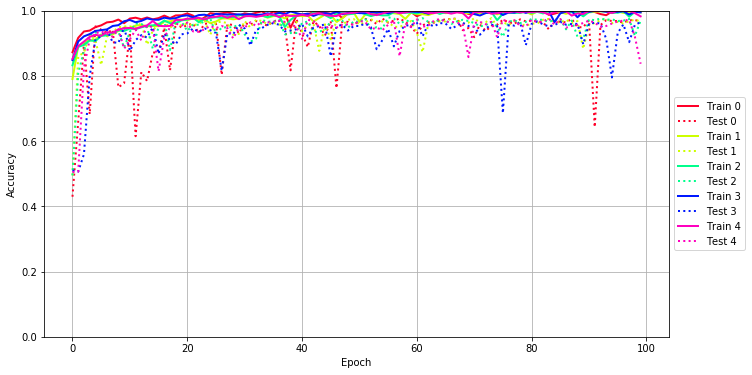

In [10]:
plot_acc(history)

In [11]:
def plot_loss(history):
    figure = plt.gcf()
    figure.set_size_inches(14, 6)
    ax = plt.subplot()
    #plt.title('Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    colors = iter(colormap.gist_rainbow(np.linspace(0, 1, len(history))))
    for i in range(len(history)):
        color=next(colors)
        plt.plot(history[i].history['loss'], label='Train '+str(i), color=color, linestyle = 'solid', linewidth=2.0)
        plt.plot(history[i].history['val_loss'], label='Test '+str(i), color=color, linestyle = 'dotted', linewidth=2.0)
    plt.legend()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.show()

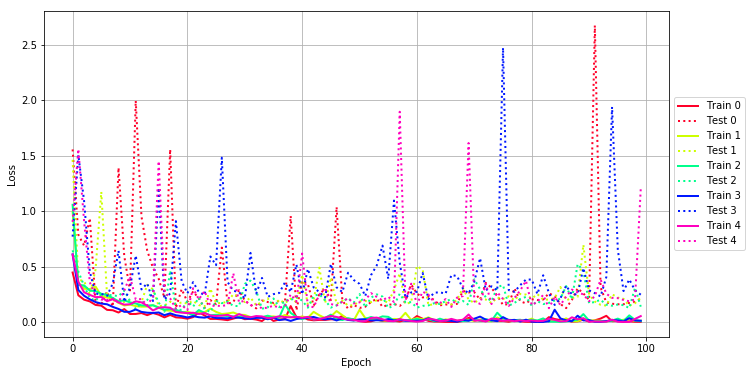

In [12]:
plot_loss(history)

Plotting the confusion matrix


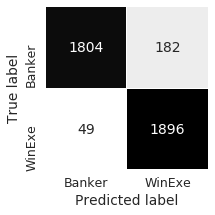

In [13]:
import seaborn as sns

print("Plotting the confusion matrix")
figure = plt.gcf()
figure.set_size_inches(5, 3)
sns.set(font_scale=1.25)
hm = sns.heatmap(conf_mat, cbar=False, annot=True, square=True,
                 fmt='.0f', annot_kws={'size': 14}, linewidth = 0.1, cmap = 'binary',
                 yticklabels=list_fams, xticklabels=list_fams)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

Plotting the confusion matrix normalized


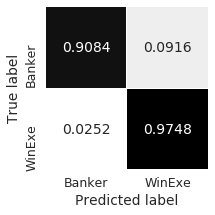

In [14]:
import seaborn as sns

print("Plotting the confusion matrix normalized")
conf_mat_norm = conf_mat/np.sum(conf_mat,axis=1,keepdims=True)  # Normalizing the confusion matrix

figure = plt.gcf()
figure.set_size_inches(5, 3)
sns.set(font_scale=1.25)
hm = sns.heatmap(conf_mat_norm, cbar=False, annot=True, square=True,
                 fmt='.4f', annot_kws={'size': 14}, linewidth = 0.1, cmap = 'binary',
                 yticklabels=list_fams, xticklabels=list_fams)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [15]:
for h in history:
    print(h.history)

{'acc': [0.8724554707379135, 0.9166666666666666, 0.9360687022900763, 0.9389312977099237, 0.9494274809160306, 0.9548346055979644, 0.964058524173028, 0.9659669211195929, 0.97264631043257, 0.9615139949109415, 0.9758269720101781, 0.9783715012722646, 0.9736005089058524, 0.9790076335877863, 0.9732824427480916, 0.9770992366412213, 0.9847328244274809, 0.9770992366412213, 0.9853689567430025, 0.9856870229007634, 0.9914122137404581, 0.9847328244274809, 0.9688295165394402, 0.9790076335877863, 0.9920483460559797, 0.9901399491094147, 0.9917302798982188, 0.9945928753180662, 0.9904580152671756, 0.9850508905852418, 0.9917302798982188, 0.9888676844783715, 0.9933206106870229, 0.9980916030534351, 0.9860050890585241, 0.9971374045801527, 0.9923664122137404, 0.9926844783715013, 0.9475190839694656, 0.9840966921119593, 0.9850508905852418, 0.989821882951654, 0.9945928753180662, 0.9942748091603053, 0.9933206106870229, 0.9904580152671756, 0.9936386768447837, 0.9770992366412213, 0.9914122137404581, 0.9923664122137

In [16]:
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_acc(history):
    train_scores = np.zeros((len(history),len(history[0].history['acc'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold].history['acc']
    test_scores = np.zeros((len(history),len(history[0].history['val_acc'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold].history['val_acc']
    epochs = np.linspace(0, len(history[0].history['acc']), len(history[0].history['acc']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.0))
    plt.show()

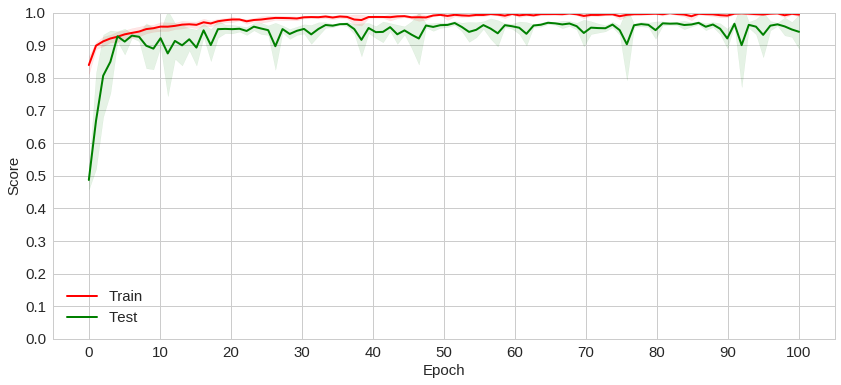

In [17]:
plot_mean_acc(history)

In [18]:
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_loss(history):
    train_scores = np.zeros((len(history),len(history[0].history['loss'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold].history['loss']
    test_scores = np.zeros((len(history),len(history[0].history['val_loss'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold].history['val_loss']
    epochs = np.linspace(0, len(history[0].history['loss']), len(history[0].history['loss']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    plt.show()

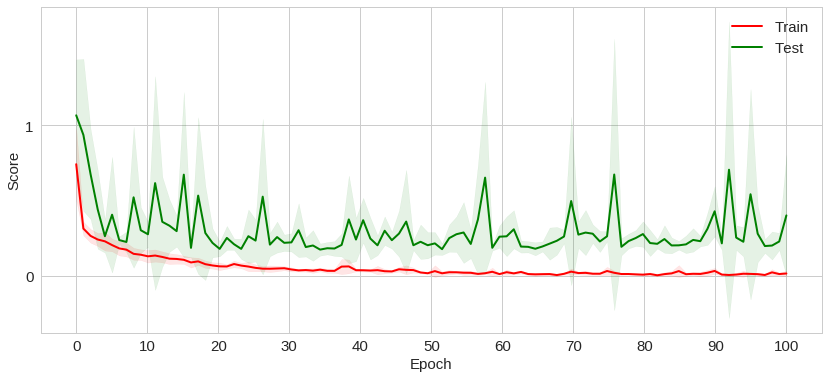

In [19]:
plot_mean_loss(history)

In [21]:
hist = [{'acc': [0.8724554707379135, 0.9166666666666666, 0.9360687022900763, 0.9389312977099237, 0.9494274809160306, 0.9548346055979644, 0.964058524173028, 0.9659669211195929, 0.97264631043257, 0.9615139949109415, 0.9758269720101781, 0.9783715012722646, 0.9736005089058524, 0.9790076335877863, 0.9732824427480916, 0.9770992366412213, 0.9847328244274809, 0.9770992366412213, 0.9853689567430025, 0.9856870229007634, 0.9914122137404581, 0.9847328244274809, 0.9688295165394402, 0.9790076335877863, 0.9920483460559797, 0.9901399491094147, 0.9917302798982188, 0.9945928753180662, 0.9904580152671756, 0.9850508905852418, 0.9917302798982188, 0.9888676844783715, 0.9933206106870229, 0.9980916030534351, 0.9860050890585241, 0.9971374045801527, 0.9923664122137404, 0.9926844783715013, 0.9475190839694656, 0.9840966921119593, 0.9850508905852418, 0.989821882951654, 0.9945928753180662, 0.9942748091603053, 0.9933206106870229, 0.9904580152671756, 0.9936386768447837, 0.9770992366412213, 0.9914122137404581, 0.9923664122137404, 0.9987277353689568, 0.9996819338422391, 0.9984096692111959, 0.9923664122137404, 0.9971374045801527, 0.9961832061068703, 0.9955470737913485, 0.9987277353689568, 0.9949109414758269, 0.9958651399491094, 0.982824427480916, 0.9907760814249363, 0.9961832061068703, 0.9984096692111959, 0.9993638676844784, 1.0, 1.0, 1.0, 0.9980916030534351, 0.9895038167938931, 0.9907760814249363, 0.9958651399491094, 0.996501272264631, 0.9942748091603053, 0.9961832061068703, 0.9977735368956743, 0.9996819338422391, 0.9942748091603053, 0.9980916030534351, 0.9996819338422391, 0.9996819338422391, 1.0, 0.9996819338422391, 0.9869592875318066, 0.9907760814249363, 0.9955470737913485, 0.9933206106870229, 0.9990458015267175, 0.9984096692111959, 0.9939567430025446, 0.9980916030534351, 0.9958651399491094, 0.9895038167938931, 0.9860050890585241, 0.9971374045801527, 0.996501272264631, 0.9990458015267175, 0.9980916030534351, 0.9996819338422391, 0.9996819338422391], 'val_loss': [1.555674539284906, 0.7861240556158287, 0.6885646505409209, 0.9359607775299189, 0.17040828336148583, 0.1588249676866786, 0.2750345911911134, 0.13815613670376387, 1.3906361485615917, 0.5939853982396396, 0.28472974437100784, 1.9949009740367778, 0.9508718233556758, 0.6442048743182587, 0.4881113310139792, 0.3894538166335153, 0.21781001150181453, 1.5555300375401804, 0.12709363760116593, 0.2960638625186654, 0.18155362468504696, 0.27604930405394057, 0.2117265721054078, 0.12613419503484777, 0.19731187041509562, 0.15982839954588585, 0.6705053945440989, 0.16573259381404598, 0.178355300304358, 0.28684856661203706, 0.1933634189451889, 0.15463034273746507, 0.12253239354428751, 0.19369110093349082, 0.1799956048866012, 0.17192286903007853, 0.190433897872827, 0.1739717879471058, 0.9558153151708455, 0.10417065836650141, 0.371583220801802, 0.3420924980091606, 0.14707871031470532, 0.25157910027928027, 0.29887091598201754, 0.19644539680549689, 1.036749143485368, 0.19520118038833917, 0.11950537985784808, 0.15305508566686582, 0.12678563433404647, 0.1375446629807311, 0.18019033319462804, 0.20961554900043688, 0.13654586430144966, 0.1540702078858298, 0.16264251458933138, 0.14433748615028497, 0.18766421861422936, 0.3390482523794086, 0.25589821482931646, 0.22125403200905755, 0.22847940105748304, 0.1987551452116887, 0.15007777611869702, 0.15772365103671748, 0.15580001969839427, 0.16375255678716252, 0.2806395888328552, 0.26665867734440096, 0.26877640822033716, 0.20130753964114712, 0.3527386817072898, 0.3072283332834925, 0.23645301348584635, 0.15315634032753989, 0.16218056092428157, 0.30380773771438496, 0.18643167691653806, 0.16785626717302604, 0.20518357453532304, 0.19765096325485723, 0.20278075954877137, 0.25909831860425775, 0.23220721648339912, 0.16159620932498628, 0.12500589683396313, 0.19896712071640002, 0.3041533984638877, 0.2574767850131137, 0.19879463133445807, 2.6732435809152495, 0.31137331387374534, 0.1763436380650119, 0.16433996978486054, 0.15995833111075505, 0.16043040375356898, 0.17184972235816234, 0.18160123548624943, 0.21017521463619757], 'val_acc': [0.42947903476191596, 0.6607369758576874, 0.899618806121007, 0.6823379917702196, 0.9517153753713247, 0.941550191657516, 0.9313850068833959, 0.941550191657516, 0.7649301143583227, 0.7776365949662244, 0.9326556549138914, 0.6149936464569015, 0.8119440914866582, 0.7839898347400195, 0.8716645496015779, 0.8716645486927396, 0.9479034307496823, 0.8170266836086404, 0.9631512076457847, 0.9479034307496823, 0.955527319992967, 0.9606099110546379, 0.9313850068833959, 0.959339263554298, 0.9618805596152891, 0.9606099115847936, 0.8030495555761354, 0.9593392630241423, 0.9555273194628113, 0.930114359383056, 0.9618805590851334, 0.9567979674933069, 0.9682337997677668, 0.9593392640844537, 0.9542566719624714, 0.9669631512071156, 0.9720457438592535, 0.955527319992967, 0.8170266835329039, 0.9745870399202446, 0.9301143583227446, 0.8881829725590261, 0.9669631517372713, 0.9529860228716646, 0.9237611183217399, 0.9682337992376112, 0.7623888196605891, 0.96569250317662, 0.96569250317662, 0.9555273194628113, 0.9695044477982624, 0.9745870399202446, 0.9707750952986023, 0.9593392630241423, 0.9758576874205845, 0.9631512076457847, 0.9695044477982624, 0.9758576874205845, 0.96569250317662, 0.951715374841169, 0.9288437108224047, 0.9542566719624714, 0.9644218551461246, 0.963151207115629, 0.9695044477982624, 0.9733163913595934, 0.974587039390089, 0.9758576874205845, 0.940279542718182, 0.9466327837794981, 0.9186785261997577, 0.9580686155238024, 0.9377382470358736, 0.9529860228716646, 0.9567979674933069, 0.9720457433290979, 0.9644218562064358, 0.9593392630241423, 0.9733163913595934, 0.9669631512071156, 0.9695044472681067, 0.9669631512071156, 0.9644218551461246, 0.9428208386277002, 0.9682337992376112, 0.9656925037067757, 0.9644218562064358, 0.9745870399202446, 0.9491740793103336, 0.9491740787801779, 0.9707750952986023, 0.6429479034307497, 0.9555273189326556, 0.9707750952986023, 0.9682337992376112, 0.9682337992376112, 0.963151207115629, 0.970775095828758, 0.9707750952986023, 0.9682337992376112], 'loss': [0.4458204369053586, 0.24057406425931072, 0.20114829570396256, 0.18556956838669478, 0.1537632287193194, 0.14726190809302658, 0.10938644009161239, 0.10591157721047487, 0.08523937298160321, 0.11669760538649013, 0.07199982243279617, 0.07239609978780265, 0.08059966430523013, 0.06168874358383906, 0.0810805900975038, 0.06588116241559747, 0.04148042313730861, 0.06352197632025311, 0.0417667230267259, 0.038404135726648206, 0.029582926133202042, 0.044005775517302996, 0.08782446880187393, 0.058676925737827866, 0.02728611298818402, 0.02789093261422754, 0.02326717520601877, 0.016622468364086124, 0.03058218792675249, 0.04453579350534599, 0.02517016090923072, 0.02952035840523119, 0.02200721620932179, 0.00830769246045243, 0.049194818795744555, 0.009125988916300667, 0.022637855551376013, 0.025461549199060074, 0.1431182084519786, 0.04359723000805564, 0.046140890002562295, 0.02204512003450785, 0.015193944436491469, 0.01880027089970312, 0.01864214602688389, 0.024190464662895247, 0.0240645085313845, 0.056042032652655, 0.023056541705459923, 0.02591879645856595, 0.008841725518783606, 0.0015999769325274222, 0.005700714244994742, 0.02269006568621758, 0.010193043710063436, 0.011486013765293472, 0.010560884642121193, 0.004637442267739138, 0.01762977953053138, 0.014135923501727368, 0.05340980155112144, 0.029062689602234768, 0.009824020267930512, 0.004275384879380628, 0.003859820263739954, 0.0006680449141041757, 0.0002242074903942597, 0.0001396176837039566, 0.009148781642985566, 0.037180736251522725, 0.026522453963845723, 0.01084105205625807, 0.007854090277382028, 0.016127072044936824, 0.01164383835239, 0.009342050479252658, 0.002310026741127796, 0.015811174031507627, 0.006441410598157926, 0.001494071109571917, 0.0017151410287663221, 0.00030340880584700216, 0.0009383572583243435, 0.0437860514130337, 0.026879504815063137, 0.017103302832168547, 0.01664385048102292, 0.003169049283397117, 0.005869019673338581, 0.021459627769653135, 0.0042171915261981045, 0.01477927194535799, 0.03076212379590001, 0.05572289769553039, 0.007210218547216516, 0.009412186470644629, 0.0026181137701223748, 0.0065357186856249945, 0.0019298092584064158, 0.0018239065641438908]},
{'acc': [0.7904610493224831, 0.8909379968203498, 0.9023847376788553, 0.9081081081460125, 0.9112877583655341, 0.9271860097284726, 0.9246422893671239, 0.9268680445151033, 0.9376788553259141, 0.9484896661556772, 0.9465818759936407, 0.9542130366417865, 0.9558028616852147, 0.95230524647975, 0.9529411764895405, 0.9523052464228935, 0.9672496025816246, 0.9669316375198728, 0.9720190779014308, 0.972972972972973, 0.9697933227344993, 0.9771065184725108, 0.9697933227534514, 0.9723370429252782, 0.9618441973278367, 0.9666136724960255, 0.9758346581875994, 0.9761526232114467, 0.9732909379968203, 0.9758346581875994, 0.9818759936406996, 0.9875993640699523, 0.9841017488076311, 0.9856915739458202, 0.9783783783783784, 0.983147853736089, 0.9841017488076311, 0.9761526232114467, 0.9860095389507154, 0.9875993640699523, 0.9828298887122416, 0.9844197138693829, 0.9669316375577772, 0.9774244833068363, 0.9875993640699523, 0.9866454690363146, 0.9656597774244833, 0.9761526232114467, 0.9914149443561209, 0.9942766296276038, 0.9656597774623877, 0.9875993640889045, 0.9910969793322735, 0.992368839427663, 0.9952305246422893, 0.9939586645468999, 0.9920508744038156, 0.9898251194264058, 0.9748807631160572, 0.9939586645468999, 0.9888712241653418, 0.9891891891891892, 0.9863275039745628, 0.9926868044515104, 0.9965023847376788, 0.992368839427663, 0.9936406995230525, 0.9961844197138314, 0.9917329093799682, 0.9920508744038156, 0.9971383147853736, 0.992368839427663, 0.9920508744038156, 0.9984101748807631, 0.9888712241653418, 0.9942766295707473, 0.9936406995230525, 0.9971383148043258, 0.9952305246422893, 0.9965023847376788, 0.9882352941176471, 0.9980922098569157, 0.9926868044515104, 0.997456279809221, 0.9955484896661367, 0.9961844199033534, 0.9901430842607313, 0.9971383147853736, 0.9971383147853736, 0.9917329093799682, 0.9945945945945946, 0.9965023847376788, 0.9980922098569157, 0.9984101748997153, 0.992368839427663, 0.997456279809221, 0.9930047694753578, 0.9920508744038156, 0.9977742448330683, 0.9945945945945946], 'val_loss': [1.4619941749342222, 0.3816631741196145, 0.368192164232106, 0.24824568299391797, 0.47405908721245577, 1.172453293666888, 0.2410657522635909, 0.19910933426166613, 0.1718981896192973, 0.18092543554063364, 0.19255239554413098, 0.1726931709767753, 0.17972548074224068, 0.3356834458034372, 0.2943608961696085, 0.14314659805281169, 0.14826233892609145, 0.18340048125681988, 0.16481633385306854, 0.17551333546335157, 0.16674482273577734, 0.18976932570797986, 0.15266440469124673, 0.14066647474225089, 0.30082998429034047, 0.16970499505883713, 0.17157679341103094, 0.18155345272180404, 0.25060030670111416, 0.228232925776724, 0.1791051838786339, 0.22045032509647633, 0.1486801369727113, 0.1836772759866536, 0.21261275037316665, 0.14330775413956048, 0.20128926417361423, 0.16908837961235604, 0.21043940397268565, 0.1804239814585601, 0.4252453190688507, 0.15444577565302944, 0.19317141545192354, 0.48984110413792215, 0.16965861407549385, 0.40024735671930184, 0.1619661555651566, 0.19179031147198566, 0.14792847723531852, 0.15095106718197357, 0.18738044904421722, 0.19050388752685224, 0.1785217126196275, 0.19463590766380925, 0.19912236067272043, 0.17168542428259706, 0.2916460796928806, 0.438436631957524, 0.16073329044676576, 0.17881042606002678, 0.5037001550669835, 0.47163577815197866, 0.14959302341740854, 0.16313063374339276, 0.15831595849193653, 0.1762666502432444, 0.15723783312197473, 0.2002831057637339, 0.30594281720273253, 0.20189015162248478, 0.17167204394260063, 0.20902316360225642, 0.2025186470552373, 0.17097792194548622, 0.22061232696393973, 0.20673019465642006, 0.23171875404035017, 0.195785315928067, 0.25329645852831284, 0.247105294196338, 0.211759599897985, 0.25100616082672045, 0.2009551396851202, 0.20207324013232908, 0.215328817753726, 0.315518386211744, 0.1952950192678189, 0.21590786944872464, 0.22679514720470062, 0.6962935961517503, 0.246291318484662, 0.1846376575935992, 0.1545355616823288, 0.14738819605912698, 0.24990774744136068, 0.2200740623980063, 0.2087451118853538, 0.1455635622657839, 0.16935381897857613, 0.21851938832872642], 'val_acc': [0.494910941475827, 0.860050891040239, 0.871501272264631, 0.9262086521578199, 0.9096692113475945, 0.8333333342433279, 0.9198473276376118, 0.9338422391857506, 0.9491094147582697, 0.951653944778685, 0.951653944778685, 0.9478371501272265, 0.9618320610687023, 0.8956743002544529, 0.9389312971032606, 0.960559796437659, 0.9643765903307888, 0.9478371501272265, 0.9592875318066157, 0.9541984732824428, 0.9605597971959878, 0.9541984732824428, 0.960559796437659, 0.9694656488549618, 0.926208651399491, 0.9643765903307888, 0.9656488549618321, 0.9618320610687023, 0.9262086521578199, 0.9287531806615776, 0.9681933842239185, 0.9478371501272265, 0.9720101781170484, 0.9681933842239185, 0.9580152671755725, 0.9631043256997456, 0.956743002696195, 0.9631043256997456, 0.9376590330788804, 0.9656488549618321, 0.9363867684478372, 0.9567430025445293, 0.9592875318066157, 0.8765903307888041, 0.9580152671755725, 0.9122137398513522, 0.9694656488549618, 0.9541984732824428, 0.9720101781170484, 0.9745547073791349, 0.9567430025445293, 0.9643765903307888, 0.9732824427480916, 0.9669211195928753, 0.9669211195928753, 0.9656488549618321, 0.950381679389313, 0.950381679389313, 0.9567430025445293, 0.9681933842239185, 0.9325699745547074, 0.8727735365923428, 0.9592875318066157, 0.9656488549618321, 0.9669211195928753, 0.9669211195928753, 0.9758269720101781, 0.9732824427480916, 0.9592875318066157, 0.9631043256997456, 0.9770992366412213, 0.9618320610687023, 0.9643765903307888, 0.9770992366412213, 0.9516539440203562, 0.9656488549618321, 0.955470737913486, 0.9694656488549618, 0.960559796437659, 0.9529262086513995, 0.960559796437659, 0.960559796437659, 0.9720101781170484, 0.9745547073791349, 0.9656488549618321, 0.9631043256997456, 0.9720101781170484, 0.9618320610687023, 0.9681933842239185, 0.8829516539440203, 0.9567430025445293, 0.9618320610687023, 0.9707379134860051, 0.9758269720101781, 0.9618320604620393, 0.9656488549618321, 0.960559796437659, 0.9681933842239185, 0.9720101781170484, 0.9669211195928753], 'loss': [0.9940824972237616, 0.35387360645259697, 0.29927962827000215, 0.2971328385304571, 0.3196392847926893, 0.2369982645223554, 0.21962993428798094, 0.21429231996945622, 0.17289297075169266, 0.14913714764986205, 0.1565428077434271, 0.14361355429802486, 0.13786713550480256, 0.13886791395885198, 0.1518313970635919, 0.1324106399280823, 0.10485820944623842, 0.10250800627687967, 0.09270948961803568, 0.08574688521351528, 0.09323371381562541, 0.07723972046413179, 0.09028121660358386, 0.08878073425688122, 0.12039747377576245, 0.09119003896848765, 0.07160408697764734, 0.07707307585566904, 0.0855983391806886, 0.06516012678364076, 0.06354701818160961, 0.04513956347320507, 0.043217937508634986, 0.04307962010580519, 0.0495360344213053, 0.05038092347522324, 0.04167018144047969, 0.06323893196327059, 0.04535428009344641, 0.034727668442361026, 0.04993158227785574, 0.038451950340302264, 0.09174151077795484, 0.0601715987811786, 0.0356215545309438, 0.04989297384557585, 0.09838225883824102, 0.061468195319412625, 0.023590492209810496, 0.014613462673183324, 0.1100103154636339, 0.035204057842907636, 0.027809679089336167, 0.019579633898975324, 0.012175980871187935, 0.01649844290256287, 0.027728135978930004, 0.025740398885164002, 0.08261979393815008, 0.018512171648560456, 0.034847028803602985, 0.02417214432692774, 0.041575538327055725, 0.01757030814152436, 0.008164792559487192, 0.023988928286127736, 0.015729407109049947, 0.010083090499364948, 0.019986249512979105, 0.020620574757333886, 0.007760536295699571, 0.022787832107272966, 0.01967531475872411, 0.005542014477194099, 0.040917004424017106, 0.014904080625022046, 0.01544961275334621, 0.011488694965059089, 0.012915031657831968, 0.0110813839293795, 0.030605663779407846, 0.0055981573100405005, 0.021143220111679004, 0.00795455373095723, 0.0077125382074067, 0.007742488902333759, 0.03265458375046367, 0.006677207311235691, 0.005893009020366771, 0.030561316209585764, 0.015887198580905725, 0.012850730218530304, 0.010535214598115166, 0.005117311474233451, 0.014780474957859733, 0.009395414779338397, 0.020383592022840426, 0.02298385622927905, 0.008092180828912646, 0.011405450572512913]},
{'acc': [0.832432432489289, 0.8890302068667875, 0.8947535771065183, 0.908744038174755, 0.9068362482022405, 0.9224165342191445, 0.9243243245138463, 0.9316375200623359, 0.9395866455069027, 0.9376788553448664, 0.9449920509123082, 0.9434022257930713, 0.9488076311605723, 0.9535771065751396, 0.9548489666515769, 0.9580286168521462, 0.969475357729604, 0.9615262321144674, 0.9621621622000666, 0.9701112877583465, 0.9726550079491256, 0.9790143085018819, 0.9643879173669981, 0.9751987281399046, 0.9777424483306836, 0.9799682034976153, 0.9783783783783784, 0.9815580286168522, 0.9793322734499205, 0.9869634340222575, 0.9847376788553259, 0.983147853736089, 0.9850556439170777, 0.9847376790448479, 0.9799682034976153, 0.985691573926868, 0.9841017488834399, 0.9497615262321145, 0.9717011128775834, 0.9847376788553259, 0.9898251192558362, 0.9847376788553259, 0.9942766295896994, 0.9885532591414944, 0.986327503993515, 0.9771065183019411, 0.9901430842607313, 0.993322734499205, 0.9885532591414944, 0.9907790143084261, 0.9952305246422893, 0.9891891892081414, 0.983147853736089, 0.9879173292833217, 0.9853736089124968, 0.98569157411639, 0.9952305246612415, 0.9952305246422893, 0.9936406997125744, 0.9942766295896994, 0.9914149443561209, 0.9961844197138314, 0.992368839427663, 0.9974562799987429, 0.989825119236884, 0.9961844197138314, 0.9939586645468999, 0.9971383147853736, 0.9971383147853736, 0.9952305246422893, 0.9920508744038156, 0.9965023847376788, 0.9930047694753578, 0.9961844197896402, 0.9707472178060413, 0.9907790143084261, 0.9939586645468999, 0.993322734688727, 0.9930047694753578, 0.9971383147853736, 0.9930047696648796, 0.9961844197327837, 0.9914149443561209, 0.9990461049284579, 0.9990461049284579, 1.0, 0.9984101748807631, 0.9949125596184419, 0.9942766295896994, 0.9825119236883942, 0.9958664546899841, 0.9996820349761526, 0.9984101748807631, 0.9971383147853736, 0.9952305246422893, 0.993322734499205, 0.9984101749186675, 0.9815580286358043, 0.9961844197138314, 0.9980922098569157], 'val_loss': [0.6462032243268181, 0.4550163797067322, 0.3269293302191426, 0.21614523685084652, 0.19190473289586812, 0.25072379624494767, 0.24589661359028658, 0.2401843848537521, 0.2331456779656368, 0.28395595229005693, 0.1891500920853542, 0.11717529061935254, 0.17024462960600326, 0.19799796608098932, 0.29067900454573353, 0.1754088180243931, 0.09299720867605686, 0.4635341515013375, 0.11021875835831915, 0.10966329480836562, 0.1900269009229791, 0.13807647021691155, 0.21963434616689104, 0.11520040739071734, 0.09027776008462368, 0.19049117856353293, 0.16946170924577397, 0.18253689506636225, 0.14494848645673758, 0.14333834026824047, 0.34394094505455536, 0.3729226692858802, 0.2796272760584154, 0.12017409357066923, 0.1306500961914014, 0.212013220165545, 0.13290740744137908, 0.1958339206646872, 0.1972543634000322, 0.22586912978748594, 0.19250302731223007, 0.12903564712879873, 0.23664050535997969, 0.24970371537482242, 0.19515869764577948, 0.12975944534095796, 0.1507278625279442, 0.18439574369200346, 0.21414773165464557, 0.17597672266040998, 0.2516849718101602, 0.13203616080326963, 0.21972296952860046, 0.24902629806972462, 0.2293413745348387, 0.12453754353319217, 0.14879139014353868, 0.2544188345906872, 0.17876041043139435, 0.17847123290261055, 0.12918506538271476, 0.1451600599134728, 0.14969383360844393, 0.1692099556956042, 0.16255825264651907, 0.18762836959421855, 0.20500340431225825, 0.17430566432728828, 0.19016227812402328, 0.15396670114741312, 0.3847617278818578, 0.2953886288850098, 0.2226900793499439, 0.18759701531527415, 0.3145231981905815, 0.3320959854726478, 0.14630699326287488, 0.17254431242374993, 0.20725950055563722, 0.22640866483139693, 0.145904274917461, 0.1878822287605704, 0.1613863524312677, 0.1714982124102588, 0.19364254388370988, 0.20978592105926167, 0.32359914020955105, 0.20430955138347381, 0.5215665104848738, 0.46253720298883416, 0.1677847100041437, 0.18132871375907225, 0.1999394991866918, 0.155838851764713, 0.14669279355147763, 0.15746086729221218, 0.1513550976663354, 0.12605247442543469, 0.30932607342022217, 0.1380189596112514], 'val_acc': [0.494910941475827, 0.8078880407124682, 0.8778625957231788, 0.926208651399491, 0.9338422391857506, 0.9223918575063613, 0.9274809167888631, 0.9312977099236641, 0.9351145045751227, 0.8867684487471447, 0.9351145045751227, 0.960559796437659, 0.9592875318066157, 0.9478371501272265, 0.8829516540956861, 0.950381679389313, 0.9694656488549618, 0.8791348600508906, 0.9669211195928753, 0.9669211195928753, 0.937659034595538, 0.9567430025445293, 0.9567430025445293, 0.9681933842239185, 0.9758269720101781, 0.9287531800549146, 0.9478371501272265, 0.9491094147582697, 0.9491094141516067, 0.9580152671755725, 0.9274809160305344, 0.9045801541884133, 0.9147582691134387, 0.9707379134860051, 0.9669211195928753, 0.9656488549618321, 0.9720101781170484, 0.9274809160305344, 0.9312977100753299, 0.9312977108336588, 0.9618320610687023, 0.9669211195928753, 0.9351145038167938, 0.9351145038167938, 0.9427480931197111, 0.9669211195928753, 0.9720101781170484, 0.9694656488549618, 0.9465648862545121, 0.9681933842239185, 0.9643765903307888, 0.9758269720101781, 0.9440203562340967, 0.9491094147582697, 0.9440203562340967, 0.9796437659033079, 0.9758269720101781, 0.9592875318066157, 0.9694656488549618, 0.9669211195928753, 0.9707379134860051, 0.9770992366412213, 0.9656488549618321, 0.9643765903307888, 0.9720101781170484, 0.9694656488549618, 0.9592875318066157, 0.9669211195928753, 0.9720101781170484, 0.9681933842239185, 0.9618320610687023, 0.9516539440203562, 0.9554707394301436, 0.9643765910891177, 0.9516539440203562, 0.9198473282442748, 0.9656488549618321, 0.9707379142443339, 0.9618320610687023, 0.9656488549618321, 0.9745547073791349, 0.9720101781170484, 0.9720101781170484, 0.9656488557201609, 0.9720101781170484, 0.9745547073791349, 0.9427480923613822, 0.9694656488549618, 0.9198473276376118, 0.9134860050890585, 0.9732824427480916, 0.9707379134860051, 0.9758269720101781, 0.9720101781170484, 0.9732824427480916, 0.9681933842239185, 0.9694656488549618, 0.9745547073791349, 0.9223918575063613, 0.9694656488549618], 'loss': [1.0565739572901036, 0.3333631799691053, 0.3298643694204443, 0.2832278972399822, 0.27820865769644043, 0.2542466649569464, 0.24323288181438354, 0.21649364330620757, 0.18655791134826707, 0.19571873798658435, 0.177048381788742, 0.16667346738290711, 0.1499958349146032, 0.14723215619596655, 0.15096650291323094, 0.12839243718243792, 0.11208909012270656, 0.11667172231242084, 0.11068056673048411, 0.09096792764333927, 0.08099134108777171, 0.06162700915800937, 0.10768953595896782, 0.08176165477317922, 0.06023842434447691, 0.06520490678166452, 0.05923035834428805, 0.05302839862843102, 0.050637972869559386, 0.04168175320142498, 0.047386244356496014, 0.04442420655769697, 0.0446085094178128, 0.042430263673901465, 0.0568078148155066, 0.0390547769615021, 0.03987728654035324, 0.1592363033958952, 0.08198857260408955, 0.04543351338190191, 0.02520655388980867, 0.03984536271363153, 0.022840758624363734, 0.02888566880073807, 0.037316391329519416, 0.06616223730466703, 0.026004274595315627, 0.01772814720294576, 0.034417982907961706, 0.02252993852147113, 0.016055139005687592, 0.02699571410660441, 0.044885368339873964, 0.029955210642639653, 0.050734711841743774, 0.04642337508594383, 0.013872502726948389, 0.017886713054447563, 0.017870999490457257, 0.015410892921453638, 0.02794862946048723, 0.015076019395078386, 0.024312053852017217, 0.008731334156289013, 0.02980251677878629, 0.012841147283648862, 0.014588362771876317, 0.008036387811919425, 0.008385478159519533, 0.012684465588279778, 0.02592252542288635, 0.010922326482902762, 0.02589222297498569, 0.010703417817484188, 0.08357579797381959, 0.03174198017542995, 0.019574572211827353, 0.016359867419001726, 0.020282794774209398, 0.007326541641069686, 0.020354176339110967, 0.01373583879017357, 0.03236166342318544, 0.0033798048705723587, 0.002915731670026037, 0.0012578058303918788, 0.005907071210215681, 0.01225102664398926, 0.020195336125074164, 0.0712901044130956, 0.01153224968679332, 0.0027034839159651367, 0.0047133325459559425, 0.007200875325249062, 0.012214062156566225, 0.030506102677143366, 0.008338029130385295, 0.05963295523302307, 0.018631653799967833, 0.008261792824850131]},
{'acc': [0.848648648686553, 0.9055643879552335, 0.9211446742753725, 0.9281399048000147, 0.9376788553827707, 0.9402225755735497, 0.9424483306836248, 0.9529411764705882, 0.9554848966613673, 0.9675675675675676, 0.9713831478537361, 0.964387917348046, 0.9685214626580619, 0.9761526232114467, 0.9723370429252782, 0.9720190779014308, 0.9783783783783784, 0.9751987281399046, 0.9771065183019411, 0.9834658187599364, 0.985691573926868, 0.9796502384737679, 0.9863275039745628, 0.9875993640699523, 0.983147853736089, 0.9901430842607313, 0.9885532591414944, 0.9879173290937997, 0.9882352941176471, 0.9885532591604467, 0.9875993640699523, 0.9891891891891892, 0.9866454689984102, 0.9879173290937997, 0.9920508744227677, 0.9875993640699523, 0.9936406995230525, 0.9888712241653418, 0.997456279809221, 0.992368839427663, 0.9882352941365993, 0.990779014497948, 0.983783783802736, 0.9904610492845787, 0.9923688394466151, 0.9895071542130366, 0.9968203497615262, 0.9888712241653418, 0.993322734499205, 0.9945945945945946, 0.9923688394466151, 0.992368839427663, 0.9955484896661367, 0.9939586645468999, 0.9958664546899841, 0.9917329093799682, 0.997456279809221, 0.9939586645468999, 0.9955484896661367, 0.9971383147853736, 0.9961844197138314, 0.9958664546899841, 0.9904610492845787, 0.9958664546899841, 0.9958664546899841, 0.9949125596184419, 0.9977742448330683, 0.9990461049284579, 0.9952305246422893, 0.9968203497615262, 0.9895071542698931, 0.9850556440686952, 0.9926868044515104, 0.9949125596184419, 0.997456279809221, 0.9866454689984102, 0.9942766295707473, 0.9939586645468999, 0.9990461049474101, 0.9930047694753578, 0.9993640699523052, 1.0, 1.0, 0.9993640699902097, 0.9643879173859504, 0.9917329093799682, 0.9968203497615262, 0.9984101749376197, 0.9796502384737679, 0.9968203497615262, 0.9965023847376788, 0.9990461049284579, 0.9990461049474101, 0.9968203497615262, 0.9939586645468999, 0.9965023847376788, 0.9980922100464377, 0.9882352941176471, 0.996502384756631, 0.9945945945945946], 'val_loss': [0.7694464130256012, 1.5049163840957573, 1.0909482511969013, 0.4529087976493302, 0.2535848462096304, 0.253779841250439, 0.2350839930029619, 0.3468465587508132, 0.6425849099254144, 0.18037760833102934, 0.310747116121627, 0.5989220790622704, 0.293818985308703, 0.3480392240660867, 0.1886626612821608, 1.2087043287072068, 0.20152614254305382, 0.2576111993413542, 0.9089543366034893, 0.36668735479260767, 0.2586679842332544, 0.3590159181038392, 0.2698406802239157, 0.24253493860724165, 0.5906626487693428, 0.5120983657784974, 1.4815629036243358, 0.3611456308864607, 0.2818773990276604, 0.2692396966079543, 0.2107331187620702, 0.6229145762749575, 0.2561746024296787, 0.3969150697125266, 0.2262856432452381, 0.2509854691714503, 0.26147275848113327, 0.35645426826850146, 0.26898649992283824, 0.5184226880956716, 0.24910495631188231, 0.4783777138704088, 0.31187246981537226, 0.2691732834978385, 0.2202197694131967, 0.5234061673564395, 0.31236771411948505, 0.26999051023497417, 0.44410091196161383, 0.3779626524660196, 0.3434933502343918, 0.23341592024945423, 0.4224065240604682, 0.510277515612465, 0.6888209283631643, 0.38923416156843116, 1.0948814645312743, 0.5351652971044965, 0.21737508065023983, 0.26662965295937047, 0.2721021863425733, 0.4416758502616118, 0.20586447941930847, 0.26444970366308634, 0.26718533871832845, 0.2557702337085973, 0.42386680986565173, 0.4137445683662925, 0.3029302907989369, 0.2564584634036629, 0.36531724389073733, 0.5759249953977124, 0.28478428299874115, 0.32157680681052336, 0.2827471814381371, 2.472341668697659, 0.28750779053493125, 0.27276943455469194, 0.33263216322727596, 0.38255581740851563, 0.38267527078256436, 0.2516591993844486, 0.4210545033336856, 0.2608749119199945, 0.1538174683962766, 0.21352523752623273, 0.32809670926821144, 0.24762109603848945, 0.2503600357225966, 0.48624244842276476, 0.28536469319859314, 0.2596644110013891, 0.23030797635187614, 0.40567279672363454, 1.939024547991789, 0.6540080146430405, 0.2787351426976559, 0.3839720751777405, 0.28512955930575057, 0.24581270334761088], 'val_acc': [0.510178117048346, 0.5063613231552163, 0.5597964376779913, 0.7989821881434996, 0.9122137406096811, 0.9223918578096928, 0.9402035638576246, 0.9033078877373809, 0.900763358171963, 0.9491094162749274, 0.8765903307888041, 0.9096692105892658, 0.9249363878301082, 0.9173027983755252, 0.9491094162749274, 0.8676844777648383, 0.9300254455959523, 0.9096692105892658, 0.8969465642788331, 0.927480917547192, 0.9300254455959523, 0.9452926223817976, 0.9351145041201254, 0.9452926217751345, 0.9402035617343039, 0.9312977108336588, 0.8155216278920647, 0.9312977108336588, 0.9274809169405289, 0.9567430040611868, 0.9452926223817976, 0.8931297703857034, 0.9414758278820048, 0.9465648870128408, 0.9567430040611868, 0.9618320619786969, 0.9567430040611868, 0.9363867693578317, 0.9389312980132551, 0.9427480909963903, 0.9592875327166104, 0.921119592268655, 0.947837151037221, 0.9529262101680571, 0.9580152680855671, 0.8600508907369075, 0.9516539455370139, 0.9567430034545238, 0.9389312992265813, 0.9529262101680571, 0.9529262088030652, 0.9605597979543167, 0.9491094141516067, 0.8816793890096456, 0.9096692105892658, 0.9440203556274337, 0.8905852411236168, 0.9376590324722174, 0.9541984741924373, 0.9554707394301436, 0.9631043272164032, 0.9211195937853126, 0.9592875327166104, 0.9516539449303508, 0.9618320625853599, 0.9605597973476536, 0.9440203577507543, 0.9541984747991004, 0.9631043272164032, 0.9529262095613941, 0.9503816809059706, 0.926208650792828, 0.9452926217751345, 0.9567430040611868, 0.9529262095613941, 0.6857506355256525, 0.9554707394301436, 0.9541984741924373, 0.9643765918474464, 0.89440203668507, 0.9592875333232734, 0.966921121109533, 0.9580152665689095, 0.9516539449303508, 0.9554707394301436, 0.9656488564784896, 0.9567430019378662, 0.9592875333232734, 0.9592875333232734, 0.8969465642788331, 0.9592875333232734, 0.9631043272164032, 0.9605597979543167, 0.913486004785727, 0.7951653937953725, 0.9312977093170011, 0.9580152686922302, 0.903307888344044, 0.9567430040611868, 0.9643765918474464], 'loss': [0.6092362877769197, 0.2880608091293723, 0.23633596332349913, 0.2042062422713718, 0.17966851458450947, 0.16597633838464043, 0.15965694557277216, 0.136279804935895, 0.11761371126392521, 0.09171246046908141, 0.09150371853031206, 0.11326633297108316, 0.09092686343316243, 0.083749599080823, 0.08155699668774923, 0.08597225704732304, 0.06116904934219696, 0.07826747491908377, 0.060623340237003255, 0.052700146682122175, 0.040755628229049295, 0.053104694627095106, 0.042887374328076246, 0.039100836594670486, 0.05058415902627481, 0.035301230464664414, 0.035252053872330505, 0.03282710377627388, 0.04131938349496313, 0.038941446261773614, 0.032854386316893684, 0.028193205182658235, 0.03710724382234859, 0.03771690046862627, 0.024911771488149423, 0.0375545330364879, 0.016971317750797126, 0.02461504585972864, 0.009497164093277792, 0.026409246901593235, 0.03525735740349976, 0.03855489852271133, 0.0454663204796174, 0.029198822012862054, 0.023528825127281282, 0.03185892758291512, 0.014029038533722369, 0.03250876705499813, 0.01838730768654466, 0.013409235539398183, 0.023452782375621054, 0.02379024526932009, 0.013604873632945547, 0.015696784377975986, 0.014263501797398532, 0.02643014221531391, 0.013677132500939675, 0.022188981503987796, 0.010338111746316296, 0.010178949128773374, 0.010540308301847977, 0.013897407049233049, 0.03396895105065112, 0.015491466288401333, 0.008513564742879131, 0.01467938414941037, 0.009448138989437254, 0.0028061559629942922, 0.018807449223915453, 0.01129114646906002, 0.029700202713170813, 0.04851589078122131, 0.020792359044558915, 0.015383203317387033, 0.007435063695788994, 0.04385135078325476, 0.016167952159309718, 0.01918733066731889, 0.00408537924948218, 0.02088237138379008, 0.002959284806296064, 0.0005882026160700059, 0.0008873196466597063, 0.006575350581178879, 0.11060565081684123, 0.03240115241299713, 0.01425950626364431, 0.006859691315847864, 0.05646505371191974, 0.014276790547881286, 0.016934663343844997, 0.0026400798249886846, 0.0017246895255124868, 0.0077925537628199286, 0.017757261710834433, 0.013881380007311143, 0.00518516273432469, 0.03488592943928052, 0.012341950041155327, 0.011945891618026814]},
{'acc': [0.8524642291243391, 0.8912559618821015, 0.9052464228934817, 0.9195548489855658, 0.9259141494435612, 0.9227344992429918, 0.9338632750397456, 0.9322734501100307, 0.9421303656787297, 0.9459459459838503, 0.946899841017488, 0.9443561208267091, 0.9503974562798092, 0.9548489666136725, 0.9682034976152624, 0.9535771065561873, 0.9523052464228935, 0.9532591414944356, 0.9717011128775834, 0.9713831478537361, 0.975516693353274, 0.9748807631160572, 0.978060413354531, 0.9729729729919252, 0.9793322734499205, 0.9812400635930048, 0.9847376788553259, 0.9777424483306836, 0.9844197138504307, 0.9739268680634673, 0.9828298887122416, 0.9834658187599364, 0.9809220985691574, 0.9841017488076311, 0.9891891892270935, 0.9875993640699523, 0.9802861685214627, 0.9869634340412098, 0.9837837837837838, 0.9841017488076311, 0.9879173292833217, 0.9837837837837838, 0.9907790143084261, 0.9917329095694901, 0.9866454689984102, 0.9841017488076311, 0.9834658187978408, 0.9910969793322735, 0.9914149443561209, 0.9936406995230525, 0.997456279809221, 0.9977742448330683, 0.9891891893787111, 0.9863275039745628, 0.9910969793322735, 0.9968203497615262, 0.9977742448330683, 0.9920508744038156, 0.9949125596184419, 0.9980922098569157, 0.9993640699523052, 0.9977742448330683, 0.9926868044515104, 0.992368839427663, 0.9961844197138314, 0.9949125596184419, 0.9907790143084261, 0.9945945945945946, 0.9926868044704625, 0.9758346581875994, 0.9958664546899841, 0.9952305246422893, 0.9977742448330683, 0.9904610492845787, 0.9920508744038156, 0.9968203497615262, 0.9945945945945946, 0.9977742448330683, 0.9942766295707473, 0.997456279809221, 0.9949125596184419, 0.9971383147853736, 0.9949125596373941, 0.9885532591414944, 0.9952305246422893, 0.9990461049284579, 0.9980922098758679, 0.9847376788742781, 0.9917329095694901, 0.9895071542130366, 0.9993640699523052, 0.9984101748807631, 0.9990461049284579, 0.9987281399046105, 0.9930047694753578, 1.0, 1.0, 1.0, 0.9923688394466151, 0.9825119236883942], 'val_loss': [0.9022918241927945, 1.5580065226130206, 0.910386124147107, 0.3574473659955818, 0.2339523665739683, 0.20223310722497886, 0.19802025017392544, 0.2083940372325992, 0.17670856829514636, 0.2838192670475739, 0.411407304520105, 0.20369043219218425, 0.20685004399326315, 0.14673918167143377, 0.23052918803036856, 1.4504121913356616, 0.2768401870214909, 0.2124326631057126, 0.11979760401514916, 0.15394725264986128, 0.10659211132741762, 0.30438154149071445, 0.2039954131303246, 0.2793147580439827, 0.14546452551717579, 0.14668566991430507, 0.14432678683967515, 0.1538106544421981, 0.439366006702378, 0.17698479959926078, 0.1926541793996672, 0.15149474433094795, 0.15754681702409384, 0.12177586267701096, 0.12998552813647765, 0.14705855273416518, 0.12909179926140746, 0.14018794282756594, 0.2489932217026774, 0.18441746523722286, 0.6173308208284416, 0.1422144148366066, 0.13334293555202906, 0.24546044396656547, 0.30793807492671066, 0.1620666381047503, 0.14825491059770565, 0.18304675882125307, 0.21410608611694057, 0.16714672423643237, 0.17699932618630676, 0.20058406231114428, 0.26009520756213456, 0.2259118090035351, 0.19393669257178703, 0.22767690804792312, 0.18054557569297125, 1.8953521682489907, 0.1948539296801394, 0.34542961704709957, 0.15972143326802482, 0.273471388893074, 0.2463481733836139, 0.17589137360369775, 0.16962500767362879, 0.2064217922678241, 0.13597215335512813, 0.22063685459925783, 0.23364996432807206, 1.6132561534207135, 0.18606997875742018, 0.16320493396634647, 0.3442260550557932, 0.16187600501275054, 0.26736427856841466, 0.2072223142075587, 0.1446987792622042, 0.21723829324876676, 0.28423899255669527, 0.37145580185993665, 0.15173662866556983, 0.18340378747065877, 0.24404349522376698, 0.1241554669356583, 0.22637604788686494, 0.1529143651092667, 0.22861904385215284, 0.29214650697915645, 0.2671803343888851, 0.24865252565941265, 0.18752457705325193, 0.231753446153646, 0.38240200414095954, 0.2549402221984452, 0.21761835614673564, 0.2148944970628966, 0.19853685930137877, 0.1866294856422104, 0.2036045741375166, 1.2015758980239242], 'val_acc': [0.5050890585241731, 0.5063613231646954, 0.824427481219362, 0.9122137406096811, 0.9300254452926209, 0.9363867684478372, 0.9287531806615776, 0.9198473282442748, 0.9427480909963903, 0.8829516536406888, 0.9122137404580153, 0.9414758269720102, 0.9083969474748801, 0.9541984726757797, 0.9491094147582697, 0.8142493638676844, 0.9173027997405171, 0.9491094147582697, 0.960559796437659, 0.9541984732824428, 0.9631043264580743, 0.9363867684478372, 0.9351145038167938, 0.9427480916030534, 0.9529262086513995, 0.9465648862545121, 0.9529262086513995, 0.9465648854961832, 0.9147582697201018, 0.9478371501272265, 0.9478371501272265, 0.9643765904824546, 0.9529262101680571, 0.9656488549618321, 0.9643765903307888, 0.9656488549618321, 0.9681933842239185, 0.9656488549618321, 0.9580152671755725, 0.950381679389313, 0.9134860050890585, 0.9720101781170484, 0.9681933842239185, 0.950381679389313, 0.94529262086514, 0.9541984740407715, 0.9478371501272265, 0.9567430025445293, 0.9580152671755725, 0.9567430033028581, 0.9681933842239185, 0.9656488549618321, 0.9427480909963903, 0.9478371495205634, 0.9402035623409669, 0.9567430025445293, 0.9694656488549618, 0.8600508905852418, 0.9618320618270311, 0.9491094147582697, 0.9732824427480916, 0.950381679389313, 0.9541984732824428, 0.9694656488549618, 0.9745547073791349, 0.9656488549618321, 0.9656488549618321, 0.9631043256997456, 0.9580152671755725, 0.8575063613231552, 0.9618320610687023, 0.9656488549618321, 0.9580152671755725, 0.9656488549618321, 0.9185750645232261, 0.9720101781170484, 0.9656488557201609, 0.9707379134860051, 0.9529262086513995, 0.9516539440203562, 0.9720101781170484, 0.9643765903307888, 0.9669211195928753, 0.9758269720101781, 0.9567430025445293, 0.9745547073791349, 0.9478371501272265, 0.9529262086513995, 0.9567430033028581, 0.9618320610687023, 0.9694656488549618, 0.9631043256997456, 0.950381679389313, 0.9529262086513995, 0.960559796437659, 0.9669211195928753, 0.9694656488549618, 0.9720101781170484, 0.9198473283959405, 0.8371501272264631], 'loss': [0.6077435541607806, 0.36119158192166084, 0.2682196786085259, 0.24444051987605558, 0.22345473612399566, 0.22514475003145457, 0.1875056112644119, 0.20491109720663728, 0.17684721532610906, 0.15655089607299416, 0.16007516654193496, 0.18665698220885235, 0.17668599965604576, 0.14681550895466525, 0.10407334819838808, 0.1283492160241441, 0.13367087240427117, 0.12860158228556756, 0.09028780175171591, 0.08507939119407217, 0.0793159205034162, 0.08359835334403502, 0.07212696686321914, 0.08099639537982607, 0.05868887101286735, 0.05392655932780545, 0.05738303535195906, 0.06498229726675205, 0.04466031941634104, 0.07146155626197688, 0.05118313815743797, 0.04258749490819978, 0.053779696536380706, 0.05023753303436293, 0.033929536364593546, 0.03911081678004542, 0.05198244014803012, 0.04317832488406728, 0.04180214722923615, 0.04649281256738902, 0.037514812399045416, 0.04608525146459287, 0.0222156174411325, 0.025507534339517617, 0.03987405179320155, 0.054954251705850984, 0.045292962590952085, 0.032045365328084684, 0.02184285999250573, 0.018931552746304564, 0.007547214823802386, 0.006137562390157379, 0.036607371831856174, 0.039554083054746086, 0.025082801816546742, 0.00928965335573397, 0.007001696286640842, 0.025004381380363743, 0.015897662262165067, 0.009010020348825308, 0.0032193286049318807, 0.008665153538111956, 0.028442597388917544, 0.02250936222499583, 0.008684128492568388, 0.012445254527333685, 0.02810648667305154, 0.013666986886685639, 0.019933258808870907, 0.06736468442927436, 0.010969416284193366, 0.015402639308892152, 0.004947988218463149, 0.03090988327030963, 0.026245850764306793, 0.010007251266927558, 0.01588663698999875, 0.0068962048572923625, 0.014876301739726138, 0.0075571827031153775, 0.01348883734908827, 0.007605319163008387, 0.010349364404850498, 0.028538148838514757, 0.018941428434231064, 0.004986845214978166, 0.007194082990687767, 0.04238811083288274, 0.023812782193853986, 0.03405291209204638, 0.0023917495034069093, 0.004289352460908133, 0.0033004114412921153, 0.0026370699977991785, 0.021101131427723383, 0.0017649578175546168, 0.0010155762773881333, 0.0005058443639308856, 0.027501767577762407, 0.05314163134284525]}]

In [31]:
for i,h in enumerate(hist):
    print('[%d] Epoch: %d - Max val_acc: %.4f' %(i,np.argmax(h['val_acc']),np.max(h['val_acc'])))

[0] Epoch: 54 - Max val_acc: 0.9759
[1] Epoch: 70 - Max val_acc: 0.9771
[2] Epoch: 55 - Max val_acc: 0.9796
[3] Epoch: 81 - Max val_acc: 0.9669
[4] Epoch: 83 - Max val_acc: 0.9758


In [22]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_acc(history):
    train_scores = np.zeros((len(history),len(history[0]['acc'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold]['acc']
    test_scores = np.zeros((len(history),len(history[0]['val_acc'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold]['val_acc']
    epochs = np.linspace(0, len(history[0]['acc']), len(history[0]['acc']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.09))
    plt.show()

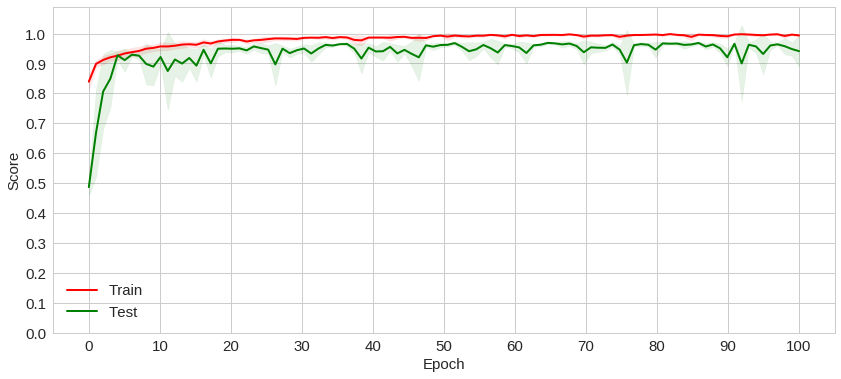

In [23]:
plot_mean_acc(hist)

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_loss(history):
    train_scores = np.zeros((len(history),len(history[0]['loss'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold]['loss']
    test_scores = np.zeros((len(history),len(history[0]['val_loss'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold]['val_loss']
    epochs = np.linspace(0, len(history[0]['loss']), len(history[0]['loss']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, alpha=0.7, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,-3.9,17.9))
    plt.show()

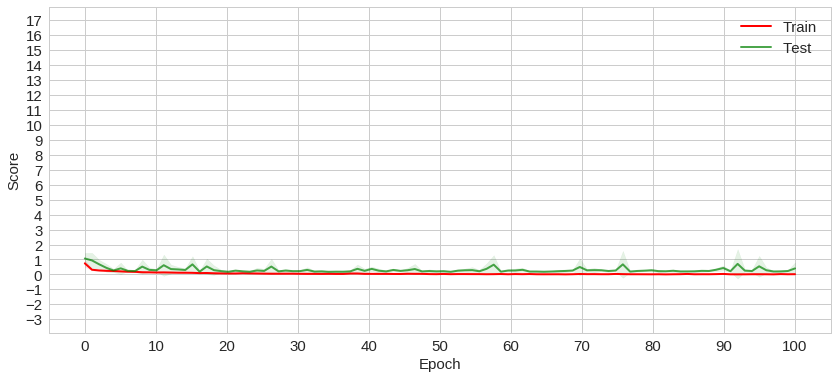

In [25]:
plot_mean_loss(hist)

In [85]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean(history):
    train_scores = np.zeros((len(history),len(history[0]['acc'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold]['acc']
    test_scores = np.zeros((len(history),len(history[0]['val_acc'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold]['val_acc']
    epochs = np.linspace(0, len(history[0]['acc']), len(history[0]['acc']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
        
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax1 = plt.subplots(1, 1, figsize=figsize)
    ax1.set_xlabel("Epoch", fontsize=text_fontsize)
    ax1.set_ylabel("Accuracy", fontsize=text_fontsize)
    ax1.grid(True)
    ax1.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax1.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax1.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax1.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="b")
    ax1.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train acc")
    ax1.plot(epochs, test_scores_mean, '-', color="b", linewidth=2.0, label="Test acc")
    ax1.plot(np.argmax(test_scores_mean), np.max(test_scores_mean), 'o', color="k", label=None)
    ax1.annotate('Max acc: %.4f (Epoch: %d)' %(np.max(test_scores_mean),np.argmax(test_scores_mean)), xy=(np.argmax(test_scores_mean), np.max(test_scores_mean)), xytext=(np.argmax(test_scores_mean)-15, np.max(test_scores_mean)-0.2), arrowprops=dict(facecolor='k', shrink=0.05),)
    ax1.tick_params(labelsize=text_fontsize)
    ax1.legend(loc="lower left", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.09))
    
    train_scores = np.zeros((len(history),len(history[0]['loss'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold]['loss']
    test_scores = np.zeros((len(history),len(history[0]['val_loss'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold]['val_loss']
    epochs = np.linspace(0, len(history[0]['loss']), len(history[0]['loss']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    ax2 = ax1.twinx()
    ax2.set_xlabel("Epoch", fontsize=text_fontsize)
    ax2.set_ylabel("Loss", fontsize=text_fontsize)
    ax2.grid(False)
    ax2.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax2.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax2.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax2.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="b")
    ax2.plot(epochs, train_scores_mean, '--', color="r", linewidth=2.0, label="Train loss")
    ax2.plot(epochs, test_scores_mean, '--', color="b", linewidth=2.0, label="Test loss")
    ax2.tick_params(labelsize=text_fontsize)
    ax2.legend(loc="lower right", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,-1.9,8.9))
    plt.show()

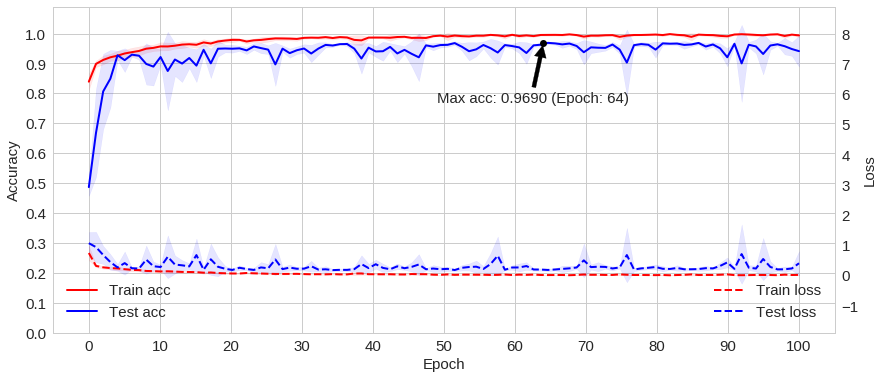

In [86]:
plot_mean(hist)